In [1]:
import gymnasium as gym
import torch
from torch import nn

from tqdm import tqdm


env = gym.make("CartPole-v1", render_mode="human")
env.action_space.seed(42)

state, info = env.reset(seed=42)  # s

for _ in range(100):
    action = env.action_space.sample()  # a according to uniform policy
    new_state, reward, done, info, _ = env.step(action)  # s', r

    if done:  # Dead
        state, info = env.reset()

    # state = new_state

c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='ansi' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


In [12]:
# make an RL agent that plays CartPole-v1

# 1. Define a neural network that takes in a state and outputs an action

class Agent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
        )

    def forward(self, state):
        return self.net(state)

# 2. Define the game and the agent

env = gym.make("CartPole-v1", render_mode="human")
env.action_space.seed(42)

agent = Agent(env.observation_space.shape[0], env.action_space.n)

# the two possible actions are to push the cart left or right

# 3. Define a l

1.0 1.0
1.0 2.0
1.0 3.0
1.0 4.0
1.0 5.0
1.0 6.0
1.0 7.0
1.0 8.0


  0%|          | 0/10000 [00:00<?, ?it/s]

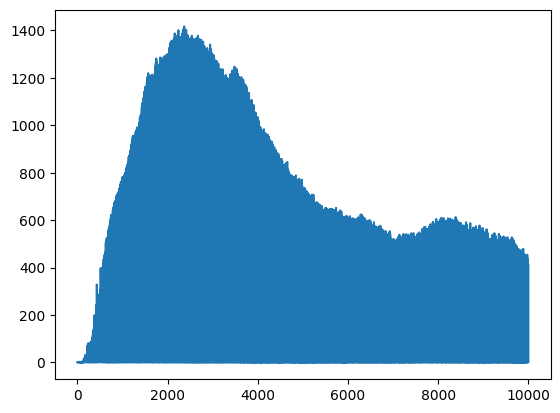

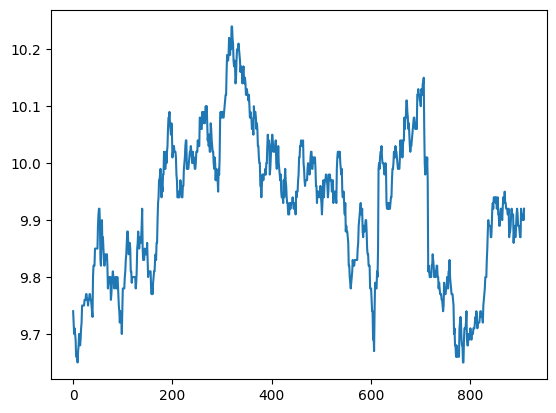

In [24]:
#forget about what we did, now do Q-learning

"""
Q-learning algorithm

1. Initialize the Q-table with zeros.
2. Start exploring actions: For each state, select action a according to the current Q-table (e.g., epsilon-greedy) and observe the reward r and the new state s'.
3. Update the Q-table using the Bellman equation: Q(s,a) = r + gamma * max(Q(s',a'))
4. Set the state to the new state.
5. If the game is over, go to step 6, else go to step 2.
6. Repeat from step 2 until the agent is trained.

Here the state space is continuous, so we can't use a Q-table. Instead, we will use a neural network to approximate the Q-table.
"""

# 1. Define a neural network that takes in a state and an action and outputs the Q-value. Or a state and outputs the Q-values for all actions.
class Q_table(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
        )

    def forward(self, state):
        return self.net(state)
    

# 2. Define the game and the agent

env = gym.make("CartPole-v1", render_mode="human")
env.action_space.seed(42)

q_table = Q_table(env.observation_space.shape[0], env.action_space.n)

# 3. Define a loop that plays the game, updates the Q-table and repeats until the agent is trained

def play(q_table, env, render=False, epsilon=0.1, optimizer=None, loss_fn=None, epochs=1e3):
    state, info = env.reset(seed=42)  # s

    if loss_fn is not None:
        losses = []

    t = 0
    times_of_deaths = []
    for i in tqdm(range(int(epochs))):
        t += 1
        if optimizer is not None:
            optimizer.zero_grad()
        # for all action, find the Q-value, then select the action with the highest Q-value greedily
        q_values = q_table(torch.tensor(state, dtype=torch.float32))
        
        p = torch.rand(1).item()
        if p < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()

        new_state, reward, done, info, _ = env.step(action)  # s', r

        if optimizer is not None:
            loss = loss_fn(q_table, q_values, state, action, reward, new_state, done)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if render:
            env.render()

        if done:  # Dead
            state, info = env.reset()
            times_of_deaths.append(t)
            t = 0
    
    if loss_fn is not None:
        return losses, times_of_deaths

# 4. Train the agent

# 4.1. Define the loss function according to the Bellman equation (Q(s,a) = r + gamma * max(Q(s',a')))
# -> loss = (Q(s,a) - (r + gamma * max(Q(s',a'))))^2

def loss_fn(q_table, q_values, state, action, reward, next_state, done, gamma=0.99):
    with torch.no_grad():
        q_values_next = q_table(torch.tensor(next_state, dtype=torch.float32))
        q_value_next = torch.max(q_values_next).item()
        q_target = reward + gamma * q_value_next * (1 - done)
    q_value = q_values[action]
    return (q_value - q_target)**2

# 4.2. Define the optimizer

optimizer = torch.optim.Adam(q_table.parameters(), lr=1e-3)

# 4.3. Train the agent

losses, tod = play(q_table, env, render=False, epsilon=0.1, optimizer=optimizer, loss_fn=loss_fn, epochs=1e2)

# 4.4. Plot the losses

import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

# 4.5. Plot the times of deaths

local_average = 100
avg_tod = [sum(tod[i:i+local_average])/local_average for i in range(len(tod)-local_average)]

plt.plot(avg_tod)
plt.show()

In [29]:
def play_batch(q_table, render=False, epsilon=0.1, optimizer=None, loss_fn=None, epochs=1e3):
    nb_games = 64
    games = [gym.make("CartPole-v1", render_mode="human") for _ in range(nb_games)]

    batch_states = []
    for env in games:
        state, info = env.reset(seed=42)  # s
        batch_states.append(state)

    if loss_fn is not None:
        losses = []

    t = 0
    times_of_deaths = []
    for i in tqdm(range(int(epochs))):
        t += 1
        if optimizer is not None:
            optimizer.zero_grad()
        # for all action, find the Q-value, then select the action with the highest Q-value greedily
        
        loss = 0
        for i, env in enumerate(games):
            state = batch_states[i]
            q_values = q_table(torch.tensor(state, dtype=torch.float32))
        
            p = torch.rand(1).item()
            if p < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_values).item()

            new_state, reward, done, info, _ = env.step(action)  # s', r

            if optimizer is not None:
                loss += loss_fn(q_table, q_values, state, action, reward, new_state, done)

        if optimizer is not None:
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if render:
            env.render()

        if done:  # Dead
            state, info = env.reset()
            times_of_deaths.append(t)
            t = 0
    
    if loss_fn is not None:
        return losses, times_of_deaths

In [32]:
q_table = Q_table(env.observation_space.shape[0], env.action_space.n)

optimizer = torch.optim.Adam(q_table.parameters(), lr=1e-3)

losses, tod = play_batch(q_table, render=False, epsilon=0.1, optimizer=optimizer, loss_fn=loss_fn, epochs=1e3)

import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

local_average = 1
avg_tod = [sum(tod[i:i+local_average])/local_average for i in range(len(tod)-local_average)]

plt.plot(avg_tod)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

OverflowError: signed short integer is less than minimum

: 

In [ ]:
#sarsa algo